In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import Model
import warnings

warnings.simplefilter('ignore', FutureWarning)

if __name__ == "__main__":
	t0 = time.time()
	featureList = ['EPS Growth', 'Volatility 180 D', 'Trailing EPS', 'Price to Cash Flow', 'EPS', 'Volume', 'Return on Assets', 'Price to Book', 'Dividend Yield', 'Total Debt to Total Equity', 'Return on Invested Capital', 'Return on Common Equity']
	train, validate, test = Model.splitData(300,3,12)
	randForest = Model.buildWithIndexesTripleClass(modelType = Model.randomForestClassifier, indexes = train, target= 'Rate of Return', features = featureList, featureLength = 12,\
									targetLength = 3, sector = "Energy", percentileTarget = 90, percentileAvoid = 10, verbose = True)
	print("Labels: ")
	print(randForest.classes_)
	print("Importances: ")
	print(randForest.feature_importances_)

[-217  -94 -181 -109  -16 -187  -61  -76 -220 -100 -169 -265 -244 -271  -40
 -298 -238  -22 -160  -97 -235 -262 -103  -58 -112 -130 -157 -259 -301 -133
 -163  -19 -175 -268  -28 -229  -34 -292  -49 -190  -91 -196 -223  -46  -64
  -25 -136  -70 -118 -142  -55 -166 -241 -256 -283  -31 -250]
[-286 -214 -145  -79 -295 -184 -253  -73 -199  -43 -115  -85 -193 -148 -151
 -277 -172 -226  -67]
[ -82 -247 -154 -121 -106 -178 -127 -208 -280 -205  -37  -52 -274 -232  -88
 -289 -202 -139 -211 -124]
Index: -217
0.0 percent complete with preparing data.
Index: -94
1.7543859649122806 percent complete with preparing data.
Index: -181
3.508771929824561 percent complete with preparing data.
Index: -109
5.263157894736842 percent complete with preparing data.
Index: -16
7.017543859649122 percent complete with preparing data.
Index: -187
8.771929824561402 percent complete with preparing data.
Index: -61
10.526315789473683 percent complete with preparing data.
Index: -76
12.280701754385964 percent complete w

In [2]:
precisions = {'seen':{}, 'above10':{}, 'above75':{}, 'above50':{}, 'above25':{}, 'above90':{}}
betterThan = {}
for prob in range(0,100,5):
	precisions['seen'][prob] = 0
	precisions['above10'][prob] = 0
	precisions['above75'][prob] = 0
	precisions['above50'][prob] = 0
	precisions['above25'][prob] = 0
	precisions['above90'][prob] = 0
for i in validate:
	addedStocks, probabilities = Model.predict_probabilities(randForest, startIndex = i, endIndex = i+11, features = featureList, sector = "Energy")
	actual = []
	for prob in range(0,100,5):
		betterThan[prob] = []
	for stock in addedStocks:
		actual.append(Model.rateOfReturn(Model.retrieveData(stock, 'Last Price', i+12, i+14, [])))
	for i in range(len(probabilities)):
		for prob in range(0,100,5):
			if probabilities[i][1] > prob / 100:
				betterThan[prob].append(1)
			else:
				betterThan[prob].append(0)
	for prob in range(0,100,5):
		if sum(betterThan[prob]) > 0:
			precisions['above10'][prob] = (Model.precision(Model.getPercentile(actual, 10),betterThan[prob]) * len(betterThan[prob]) + precisions['above10'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above75'][prob] = (Model.precision(Model.getPercentile(actual, 75),betterThan[prob]) * len(betterThan[prob]) + precisions['above75'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above50'][prob] = (Model.precision(Model.getPercentile(actual, 50), betterThan[prob]) * len(betterThan[prob]) + precisions['above50'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above25'][prob] = (Model.precision(Model.getPercentile(actual, 25), betterThan[prob]) * len(betterThan[prob]) + precisions['above25'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above90'][prob] = (Model.precision(Model.getPercentile(actual, 90), betterThan[prob]) * len(betterThan[prob]) + precisions['above90'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['seen'][prob] = precisions['seen'][prob] + len(betterThan[prob])
x = []
y90 = []
y75 = []
y50 = []
y25 = []
y10 = []
counts = []
for prob in range(0,100,5):
	print(str(prob) + " above 90th percentile: " + str(precisions['above90'][prob]))
	print(str(prob) + " above 75th percentile: " + str(precisions['above75'][prob]))
	print(str(prob) + " above 50th percentile: " + str(precisions['above50'][prob]))
	print(str(prob) + " above 25th percentile: " + str(precisions['above25'][prob]))
	print(str(prob) + " above 10th percentile: " + str(precisions['above10'][prob]))
	counts.append(sum(betterThan[prob]))
	if (precisions['above10'][prob]) > 0:
		y90.append(precisions['above90'][prob])
		y75.append(precisions['above75'][prob])
		y50.append(precisions['above50'][prob])
		y25.append(precisions['above25'][prob])
		y10.append(precisions['above10'][prob])
		x.append(prob)

print(time.time() - t0, "seconds wait time")

0 above 90th percentile: 0.104103502998
0 above 75th percentile: 0.248364504086
0 above 50th percentile: 0.494135095641
0 above 25th percentile: 0.74126377278
0 above 10th percentile: 0.888705632677
5 above 90th percentile: 0.12458858756
5 above 75th percentile: 0.27477530647
5 above 50th percentile: 0.519884332366
5 above 25th percentile: 0.758770927088
5 above 10th percentile: 0.897481180093
10 above 90th percentile: 0.151884536884
10 above 75th percentile: 0.316940018773
10 above 50th percentile: 0.541772524034
10 above 25th percentile: 0.751766674823
10 above 10th percentile: 0.880718083562
15 above 90th percentile: 0.184794629341
15 above 75th percentile: 0.354812316121
15 above 50th percentile: 0.554173418933
15 above 25th percentile: 0.738961588071
15 above 10th percentile: 0.868675617743
20 above 90th percentile: 0.203009843714
20 above 75th percentile: 0.37911050732
20 above 50th percentile: 0.57266689819
20 above 25th percentile: 0.73982090354
20 above 10th percentile: 0.8696

Counts: 
[111, 69, 48, 42, 39, 33, 29, 28, 26, 26, 23, 16, 12, 11, 11, 11, 9, 3, 2, 0]


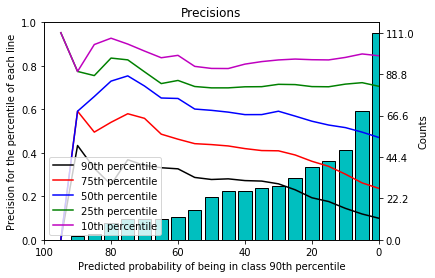

In [3]:
print("Counts: ")
print(counts)
fig = plt.figure()
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_xlim([0,100])
plt.title("Precisions")
plt.xlabel('Predicted probability of being in class 90th percentile')
plt.ylabel('Precision for the percentile of each line')
axes.invert_xaxis()
bar = axes.twinx()
rects = bar.bar(x = list(range(0,100,5)), height = list(map(lambda x: x/max(counts),counts)), width = 4, color = 'c', linestyle = 'solid', edgecolor = 'k', zorder = -1)
bar.set_yticklabels(list(map(lambda x: x * max(counts) / 5, range(0,6,1))))
bar.set_ylabel('Counts', color = 'k')
plt.plot(x, y90, color = 'k', label = "90th percentile")
plt.plot(x, y75, color = 'r', label = "75th percentile")
plt.plot(x, y50, color = 'b', label = "50th percentile")
plt.plot(x, y25, color = 'g', label = "25th percentile")
plt.plot(x, y10, color = 'm', label = "10th percentile")
plt.legend()

In [4]:
fig.savefig(str(time.time()) + 'test.jpg', dpi=900)
plt.show()

Feature ranking:
1. Volatility 180 D (0.116566)
2. Volume (0.100504)
3. Total Debt to Total Equity (0.093124)
4. Price to Cash Flow (0.089812)
5. Price to Book (0.088775)
6. EPS Growth (0.087061)
7. Return on Invested Capital (0.083496)
8. Trailing EPS (0.083228)
9. EPS (0.083183)
10. Return on Common Equity (0.083103)
11. Dividend Yield (0.045608)
12. Return on Assets (0.045541)


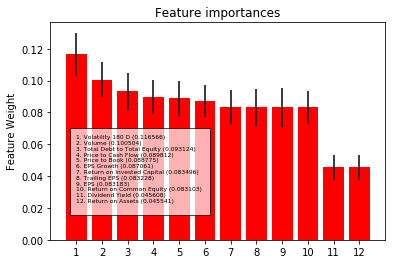

In [5]:
# adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = randForest.feature_importances_
std = np.std([est.feature_importances_ for est in randForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
textString = ''
for f in range(len(featureList)):
    print("%d. %s (%f)" % (f + 1, featureList[indices[f]], importances[indices[f]]))
    textString += "%d. %s (%f) \n" % (f + 1, featureList[indices[f]], importances[indices[f]])

# Plot the feature importances of the forest
fig2 = plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featureList)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featureList)), range(1,len(featureList)+1))
plt.xlim([-1, len(featureList)])
plt.ylabel('Feature Weight')
plt.text(0, 0.02, textString,
        bbox={'facecolor':'white', 'alpha':0.7, 'pad':6}, fontsize=6)
fig2.savefig(str(time.time()) + 'feature_importances.jpg', dpi=900)
plt.show()